In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Activation, Bidirectional
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
from keras.layers import Conv1D, MaxPooling1D
import numpy as np

#Standard Libraries
import numpy as np
import pandas as pd
import os

#Data Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

#Vectorizers
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer

#Model Evaluation
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

#Visualizations
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
data = pd.read_csv('energy_nw_clean_dataframe.csv')

In [3]:
data.head(15)

,AR_NUMBER,AR_PRIORITY,AR_SEVERITY,PRIORITY_SEVERITY,CONCAT_TEXT_FOR_WKS
0,383472,CAQ,C,CAQ:C,rcic hpcs low cst level swap fill vent suction...
1,383473,CAQ,D,CAQ:D,rcic p not start run sop rcic fill direct star...
2,383474,CAQ,D,CAQ:D,hp drop hpcs suction switchover alarm hp drop ...
3,383476,NCAQ,4,NCAQ:4,bre bre need window evaluate bre
4,383477,CAQ,D,CAQ:D,receive rod drive control sys inop alarm recei...
5,383478,CAQ,D,CAQ:D,hpcs suction switchover alarm locked fill vent...
6,383479,NCAQ,3,NCAQ:3,cw cta approx overflow operator round note due...
7,383490,CAQ,D,CAQ:D,security cctv need maintenance security cctv n...
8,383491,CAQ,C,CAQ:C,sw va change lo without screen anonymous cr de...
9,383497,NCAQ,3,NCAQ:3,ep copiers unable scan email new canon copiers...


In [4]:
X_array = data.iloc[:,[0,1,3,4]].values
Y_array = data.iloc[:,2].values

In [5]:
X = pd.DataFrame(X_array, columns=['AR_NUMBER', 'AR_PRIORITY','PRIORITY_SEVERITY','CONCAT_TEXT_FOR_WKS'])
X.head(5)

,AR_NUMBER,AR_PRIORITY,PRIORITY_SEVERITY,CONCAT_TEXT_FOR_WKS
0,383472,CAQ,CAQ:C,rcic hpcs low cst level swap fill vent suction...
1,383473,CAQ,CAQ:D,rcic p not start run sop rcic fill direct star...
2,383474,CAQ,CAQ:D,hp drop hpcs suction switchover alarm hp drop ...
3,383476,NCAQ,NCAQ:4,bre bre need window evaluate bre
4,383477,CAQ,CAQ:D,receive rod drive control sys inop alarm recei...


In [6]:
Y = pd.DataFrame(Y_array, columns=['AR_SEVERITY'])
Y.head(10)

,AR_SEVERITY
0,C
1,D
2,D
3,4
4,D
5,D
6,3
7,D
8,C
9,3


In [7]:
Y_OHE = pd.get_dummies(data=Y, drop_first=True)

In [8]:
X_OHE = pd.get_dummies(data=X, columns=['AR_PRIORITY'], drop_first=True)

In [9]:
Y_PRIORITY = data.AR_PRIORITY
Y_SEVERITY = data.AR_SEVERITY
Y_PS = data.PRIORITY_SEVERITY

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.10, random_state = 0)

In [14]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(10203, 250) (10203, 6)
(1134, 250) (1134, 6)


In [10]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(X_OHE['CONCAT_TEXT_FOR_WKS'].values)

In [11]:
X = tokenizer.texts_to_sequences(X_OHE['CONCAT_TEXT_FOR_WKS'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (11337, 250)


In [12]:
Y = pd.get_dummies(Y_OHE)
print('Shape of data tensor:', Y.shape)

Shape of data tensor: (11337, 6)


In [15]:
# Embedding
max_features = 20000
maxlen = 250
embedding_size = 128

# Convolution
kernel_size = 5
filters = 64
pool_size = 4

# LSTM
lstm_output_size = 70

In [23]:
model = Sequential()
model.add(Embedding(max_features, embedding_size, input_length=maxlen))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
model.add(MaxPooling1D(pool_size=pool_size))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(LSTM(lstm_output_size))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6))
model.add(Activation('softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 250, 128)          2560000   
_________________________________________________________________
dense_5 (Dense)              (None, 250, 128)          16512     
_________________________________________________________________
dropout_4 (Dropout)          (None, 250, 128)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 246, 64)           41024     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 61, 64)            0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 61, 64)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 61, 64)            4160      
__________

In [24]:
epochs = 4
batch_size = 64

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_split=0.1)

Train on 9182 samples, validate on 1021 samples
Epoch 1/4
9182/9182 [==============================] - 21s 2ms/step - loss: 0.3637 - acc: 0.8354 - val_loss: 0.3211 - val_acc: 0.8511
Epoch 2/4
9182/9182 [==============================] - 21s 2ms/step - loss: 0.2832 - acc: 0.8744 - val_loss: 0.2511 - val_acc: 0.8910
Epoch 3/4
9182/9182 [==============================] - 20s 2ms/step - loss: 0.2135 - acc: 0.9134 - val_loss: 0.2578 - val_acc: 0.8880
Epoch 4/4
9182/9182 [==============================] - 20s 2ms/step - loss: 0.1713 - acc: 0.9358 - val_loss: 0.2774 - val_acc: 0.8867


In [25]:
accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

1134/1134 [==============================] - 1s 544us/step
Test set
  Loss: 0.288
  Accuracy: 0.885


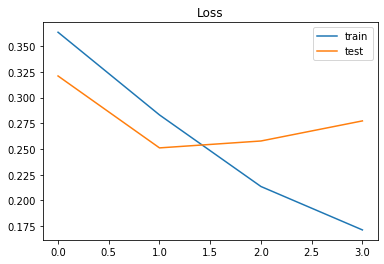

In [26]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

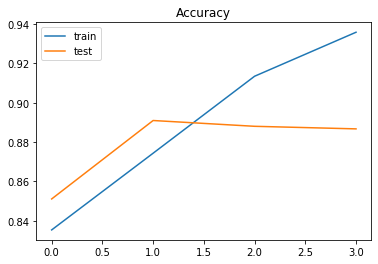

In [27]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();

In [28]:
#correct severity is CAQ D, ar number 383568
new_complaint = [' While testing the TSC public address and alerting tones per  WO 02095754 the PA was not heard in Deschutes or the Main Control Room.  The alerting tones sounded in all locations. The Control room PA and alerting tone remain fully functional.']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = ['CAQ:A, CAQ:B, CAQ:C', 'CAQ:D', 'NCAQ:1', 'NCAQ:2', 'NCAQ:3', 'NCAQ:4']
print(pred, labels[np.argmax(pred)])

[[1.2814115e-02 5.1948839e-01 1.1558462e-04 4.4111745e-04 1.8347522e-02
  4.4879323e-01]] CAQ:D
